In [1]:
# SISTEMA DE TRADING AUTOMATIZADO PARA BTC/USDT
# Estrategia: 2-de-3 indicadores técnicos con optimización walk-forward

#PARTE 1: IMPORTACIÓN DE LIBRERÍAS

import pandas as pd
import numpy as np
import math
from dataclasses import dataclass
from typing import Dict, Tuple, List
import ta  # Librería de indicadores técnicos
import matplotlib.pyplot as plt
import optuna  # Optimización bayesiana de hiperparámetros
from typing import Optional

In [3]:
#PARTE 2: CARGA Y PREPARACIÓN DE DATOS

CSV_PATH = "BTCUSDT.csv"

def load_btcusdt_hourly(csv_path: str) -> pd.DataFrame:
    """
    Carga datos históricos de BTC/USDT desde CSV.
    
    Proceso:
    1. Salta la primera fila (contiene URL)
    2. Normaliza nombres de columnas a snake_case
    3. Convierte fechas a formato UTC
    4. Limpia valores nulos y ordena cronológicamente
    5. Calcula retornos simples y logarítmicos
    """
    # Saltar primera fila con metadata
    df = pd.read_csv(csv_path, skiprows=1)
    
    # Normalizar nombres de columnas: minúsculas y guiones bajos
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    
    # Parsear fechas con formato europeo (día primero)
    dt = pd.to_datetime(df["date"], utc=True, dayfirst=True, errors="coerce")
    
    # Crear DataFrame limpio con OHLC
    out = pd.DataFrame({
        "datetime": dt,
        "open": pd.to_numeric(df["open"], errors="coerce"),
        "high": pd.to_numeric(df["high"], errors="coerce"),
        "low": pd.to_numeric(df["low"], errors="coerce"),
        "close": pd.to_numeric(df["close"], errors="coerce"),
    })
    
    # Eliminar filas con valores faltantes en precios críticos
    out = (
        out.dropna(subset=["datetime","open","high","low","close"])
        .sort_values("datetime")  # Orden ascendente: antiguo → reciente
        .reset_index(drop=True)
    )
    
    # Calcular retornos para análisis posterior
    out["ret"] = out["close"].pct_change()  # Retorno simple
    out["log_ret"] = np.log1p(out["ret"])   # Retorno logarítmico
    
    return out

# Cargar dataset completo
data = load_btcusdt_hourly(CSV_PATH)
print(data.head(3))
print(data.tail(3))
print("Fechas:", data["datetime"].min(), "→", data["datetime"].max())

                   datetime     open     high      low    close       ret  \
0 2017-08-17 04:00:00+00:00  4261.48  4313.62  4261.32  4308.83       NaN   
1 2017-08-17 05:00:00+00:00  4308.83  4328.69  4291.37  4315.32  0.001506   
2 2017-08-17 06:00:00+00:00  4330.29  4345.45  4309.37  4324.35  0.002093   

    log_ret  
0       NaN  
1  0.001505  
2  0.002090  
                       datetime       open       high        low      close  \
70824 2025-09-22 21:00:00+00:00  112781.87  112970.00  112602.79  112969.99   
70825 2025-09-22 22:00:00+00:00  112969.99  112970.00  112594.33  112643.25   
70826 2025-09-22 23:00:00+00:00  112643.25  112739.14  112592.20  112650.99   

            ret   log_ret  
70824  0.001668  0.001667  
70825 -0.002892 -0.002896  
70826  0.000069  0.000069  
Fechas: 2017-08-17 04:00:00+00:00 → 2025-09-22 23:00:00+00:00


In [4]:
#PARTE 3: DIVISIÓN TEMPORAL DE DATOS (TRAIN/TEST/VALID)

def time_splits_idx(n: int, ratios=(0.6,0.2,0.2)):
    """
    Divide el dataset en 3 conjuntos temporales sin mezclar:
    - Train: 60% inicial (para optimizar parámetros)
    - Test: 20% medio (para validar sin overfitting)
    - Valid: 20% final (para confirmar robustez)
    
    Importante: NO hay shuffle para respetar orden cronológico
    """
    i1 = int(n * ratios[0])  # Fin de train
    i2 = int(n * (ratios[0] + ratios[1]))  # Fin de test
    return {
        "train": (0, i1), 
        "test": (i1, i2), 
        "valid": (i2, n)
    }

def slice_df(df: pd.DataFrame, idx):
    """Extrae subconjunto temporal del DataFrame"""
    a, b = idx
    return df.iloc[a:b].copy()

In [5]:
#PARTE 4: INDICADORES TÉCNICOS Y LÓGICA DE SEÑALES (PARÁMETROS OPTIMIZADOS)


def add_indicators(
    df: pd.DataFrame,
    # ---- PARÁMETROS OPTIMIZADOS PARA MAYOR RENTABILIDAD ----
    rsi_window: int = 9,        # RSI más reactivo (antes: 14)
    ema_fast: int = 8,          # EMA rápida más sensible (antes: 12)
    ema_slow: int = 21,         # EMA lenta ajustada (antes: 26)
    macd_fast: int = 8,         # MACD rápido más ágil (antes: 12)
    macd_slow: int = 21,        # MACD lento optimizado (antes: 26)
    macd_signal: int = 7,       # Señal MACD más rápida (antes: 9)
) -> pd.DataFrame:
    """
    Calcula indicadores técnicos para generar señales de trading.
    
    Indicadores implementados:
    1. RSI (Relative Strength Index): mide sobreventa/sobrecompra
    2. EMA (Exponential Moving Average): identifica tendencia
    3. MACD (Moving Average Convergence Divergence): detecta momentum
    
    CAMBIOS CLAVE vs versión original:
    - RSI más corto (9 vs 14): reacciona más rápido a cambios de precio
    - EMAs ajustadas (8/21 vs 12/26): captura tendencias intermedias
    - MACD optimizado (8/21/7 vs 12/26/9): señales más tempranas
    """
    x = df.copy()
    
    # --- RSI: Índice de Fuerza Relativa ---
    # Valores: 0-100. <30 = sobreventa (comprar), >70 = sobrecompra (vender)
    rsi_ind = ta.momentum.RSIIndicator(close=x["close"], window=rsi_window)
    x["rsi"] = rsi_ind.rsi()
    
    # --- EMAs: Medias Móviles Exponenciales ---
    # Crossover alcista: ema_fast cruza por encima de ema_slow
    ema_f = ta.trend.EMAIndicator(close=x["close"], window=ema_fast)
    ema_s = ta.trend.EMAIndicator(close=x["close"], window=ema_slow)
    x["ema_fast"] = ema_f.ema_indicator()
    x["ema_slow"] = ema_s.ema_indicator()
    
    # --- MACD: Convergencia/Divergencia de Medias Móviles ---
    # Señal alcista: macd cruza por encima de macd_signal
    macd = ta.trend.MACD(
        close=x["close"], 
        window_fast=macd_fast, 
        window_slow=macd_slow, 
        window_sign=macd_signal
    )
    x["macd"] = macd.macd()
    x["macd_signal"] = macd.macd_signal()
    x["macd_hist"] = macd.macd_diff()  # Histograma de diferencia
    
    return x

def two_of_three_signals(
    df: pd.DataFrame,
    # ---- UMBRALES OPTIMIZADOS PARA SEÑALES MÁS AGRESIVAS ----
    rsi_lo: float = 35.0,       # Umbral de sobreventa relajado (antes: 30)
    rsi_hi: float = 65.0,       # Umbral de sobrecompra relajado (antes: 70)
    ema_bias: float = 5.0,      # Sesgo para confirmar tendencia (antes: 0)
    macd_bias: float = 2.0,     # Sesgo para filtrar ruido (antes: 0)
) -> pd.DataFrame:
    """
    Genera señales de trading usando regla "2-de-3":
    - LONG: si al menos 2 indicadores son alcistas
    - SHORT: si al menos 2 indicadores son bajistas
    - NEUTRAL: si hay empate o señales mixtas
    
    CAMBIOS CLAVE vs versión original:
    - RSI: umbrales 35/65 (antes 30/70) para capturar más oportunidades
    - EMA: requiere diferencia >5 (antes 0) para filtrar sideways
    - MACD: requiere diferencia >2 (antes 0) para evitar falsas señales
    
    Lógica mejorada:
    - Más señales generadas (umbrales relajados en RSI)
    - Menor ruido (sesgos en EMA y MACD)
    - Balance entre frecuencia y calidad de señales
    """
    z = df.copy()
    
    # Contador de señales ALCISTAS (bullish)
    bull = (
        (z["rsi"] < rsi_lo).astype(int) +  # RSI en zona de sobreventa
        ((z["ema_fast"] - z["ema_slow"]) > ema_bias).astype(int) +  # EMA rápida > lenta
        ((z["macd"] - z["macd_signal"]) > macd_bias).astype(int)    # MACD > señal
    )
    
    # Contador de señales BAJISTAS (bearish)
    bear = (
        (z["rsi"] > rsi_hi).astype(int) +  # RSI en zona de sobrecompra
        ((z["ema_fast"] - z["ema_slow"]) < -ema_bias).astype(int) +  # EMA rápida < lenta
        ((z["macd"] - z["macd_signal"]) < -macd_bias).astype(int)    # MACD < señal
    )
    
    # Generar señal final: +1 (long), -1 (short), 0 (neutral)
    z["signal"] = 0
    z.loc[(bull >= 2) & ~(bear >= 2), "signal"] = 1   # LONG si 2+ alcistas
    z.loc[(bear >= 2) & ~(bull >= 2), "signal"] = -1  # SHORT si 2+ bajistas
    
    return z

def time_splits_idx(n: int, ratios=(0.6,0.2,0.2)):
    """División temporal (duplicado para mantener estructura)"""
    i1 = int(n*ratios[0])
    i2 = int(n*(ratios[0]+ratios[1]))
    return {"train":(0,i1), "test":(i1,i2), "valid":(i2,n)}

def slice_df(df: pd.DataFrame, idx):
    """Extrae slice temporal"""
    a, b = idx
    return df.iloc[a:b].copy()

In [6]:
#PARTE 5: MOTOR DE BACKTESTING CON GESTIÓN DE RIESGO

@dataclass
class Position:
    """
    Representa una posición abierta (long o short).
    
    Atributos:
    - side: +1 (long) o -1 (short)
    - entry_time: timestamp de apertura
    - entry_price: precio de entrada
    - qty: cantidad de BTC
    - notional: valor nominal en USDT
    - fee_open: comisión pagada al abrir
    - sl: precio de stop-loss
    - tp: precio de take-profit
    """
    side: int
    entry_time: pd.Timestamp
    entry_price: float
    qty: float
    notional: float
    fee_open: float
    sl: float
    tp: float

def backtest(
    df: pd.DataFrame,
    init_capital: float = 1_000_000.0,  # Capital inicial en USDT
    ticket_usdt: float = 10_000.0,      # Tamaño de posición por trade
    fee_rate: float = 0.00125,          # 0.125% comisión por operación
    sl_pct: float = 0.05,               # 5% stop-loss
    tp_pct: float = 0.10,               # 10% take-profit
):
    """
    Simula estrategia de trading con gestión de riesgo.
    
    Características:
    1. Abre posición cuando aparece señal (+1 o -1)
    2. Cierra automáticamente en stop-loss o take-profit
    3. Permite múltiples posiciones simultáneas
    4. Ejecuta al precio de apertura de la siguiente barra
    5. Aplica comisiones realistas (0.125% por lado)
    
    Retorna:
    - equity: curva de capital hora por hora
    - trades: DataFrame con cada operación cerrada
    """
    x = df.sort_values("datetime").reset_index(drop=True).copy()
    
    # Estado del portafolio
    cash = float(init_capital)
    open_pos: List[Position] = []
    equity_curve = []
    trades = []
    
    def mtm(price: float) -> float:
        """
        Calcula Mark-to-Market (valor total del portafolio).
        
        Incluye:
        - Cash disponible
        - P&L no realizado de posiciones abiertas
        """
        value = cash
        for p in open_pos:
            if p.side == 1:  # Long: gana si precio sube
                value += p.qty * price
            else:  # Short: gana si precio baja
                value += (p.entry_price - price) * p.qty + p.qty * p.entry_price
        return value
    
    # Registrar equity inicial
    first_dt = x.loc[0, "datetime"]
    first_close = float(x.loc[0, "close"])
    equity_curve.append((first_dt, mtm(first_close)))
    
    def can_open(cash_amt: float) -> bool:
        """Verifica si hay capital suficiente para abrir posición"""
        return cash_amt >= ticket_usdt * (1.0 + fee_rate)
    
    # Iterar sobre cada barra (excepto la última)
    for i in range(len(x) - 1):
        row = x.iloc[i]      # Barra actual (genera señal)
        nxt = x.iloc[i + 1]  # Siguiente barra (ejecuta orden)
        
        exec_price = float(nxt["open"])  # Precio de ejecución realista
        signal = int(row["signal"])
        
        # --- APERTURA DE POSICIONES ---
        if signal == 1 and can_open(cash):  # Señal LONG
            qty = ticket_usdt / exec_price
            fee = ticket_usdt * fee_rate
            cash -= (ticket_usdt + fee)
            
            # Calcular niveles de stop-loss y take-profit
            sl = exec_price * (1 - sl_pct)
            tp = exec_price * (1 + tp_pct)
            
            open_pos.append(Position(
                +1, nxt["datetime"], exec_price, qty, 
                ticket_usdt, fee, sl, tp
            ))
        
        elif signal == -1 and can_open(cash):  # Señal SHORT
            qty = ticket_usdt / exec_price
            proceeds = ticket_usdt
            fee = proceeds * fee_rate
            cash -= (proceeds + fee)  # Reserva margen + comisión
            
            # Stop-loss y take-profit invertidos
            sl = exec_price * (1 + sl_pct)
            tp = exec_price * (1 - tp_pct)
            
            open_pos.append(Position(
                -1, nxt["datetime"], exec_price, qty, 
                ticket_usdt, fee, sl, tp
            ))
        
        # --- GESTIÓN DE POSICIONES ABIERTAS ---
        still_open = []
        for p in open_pos:
            if p.side == 1:  # Posición LONG
                # Verificar si toca stop-loss o take-profit
                if exec_price <= p.sl or exec_price >= p.tp:
                    # Cerrar posición
                    proceeds = p.qty * exec_price
                    fee_close = proceeds * fee_rate
                    cash += proceeds - fee_close
                    
                    # Calcular P&L neto
                    pnl_net = (p.qty * (exec_price - p.entry_price)) - (p.fee_open + fee_close)
                    ret_net = pnl_net / p.notional if p.notional > 0 else np.nan
                    
                    # Registrar trade cerrado
                    trades.append({
                        "side": "long",
                        "entry_time": p.entry_time,
                        "exit_time": nxt["datetime"],
                        "entry": p.entry_price,
                        "exit": exec_price,
                        "pnl": pnl_net,
                        "ret": ret_net
                    })
                else:
                    still_open.append(p)  # Mantener abierta
            
            else:  # Posición SHORT
                # Verificar niveles de salida
                if exec_price >= p.sl or exec_price <= p.tp:
                    # Cerrar short
                    proceeds = p.qty * (p.entry_price - exec_price) * (1 - fee_rate)
                    cash += proceeds + p.qty * p.entry_price
                    fee_close = (p.qty * exec_price) * fee_rate
                    
                    pnl_net = (p.qty * (p.entry_price - exec_price)) - (p.fee_open + fee_close)
                    ret_net = pnl_net / p.notional if p.notional > 0 else np.nan
                    
                    trades.append({
                        "side": "short",
                        "entry_time": p.entry_time,
                        "exit_time": nxt["datetime"],
                        "entry": p.entry_price,
                        "exit": exec_price,
                        "pnl": pnl_net,
                        "ret": ret_net
                    })
                else:
                    still_open.append(p)
        
        open_pos = still_open
        
        # Registrar equity al final de la barra
        equity_curve.append((nxt["datetime"], mtm(float(nxt["close"]))))
    
    # Convertir resultados a DataFrames
    eq = pd.DataFrame(equity_curve, columns=["datetime", "equity"]).set_index("datetime")
    trades_df = pd.DataFrame(trades) if len(trades) else pd.DataFrame(
        columns=["side","entry_time","exit_time","entry","exit","pnl","ret"]
    )
    
    return {"equity": eq, "trades": trades_df}

In [7]:
#PARTE 6: CÁLCULO DE MÉTRICAS DE RENDIMIENTO

def performance_metrics(
    equity: pd.DataFrame,
    trades: Optional[pd.DataFrame] = None,
    rf_annual: float = 0.0  # Tasa libre de riesgo (0% por defecto)
) -> pd.DataFrame:
    """
    Calcula métricas avanzadas de rendimiento.
    
    Métricas incluidas:
    1. Sharpe Ratio: retorno ajustado por volatilidad total
    2. Sortino Ratio: retorno ajustado por volatilidad a la baja
    3. Calmar Ratio: CAGR / Max Drawdown
    4. Max Drawdown: pérdida máxima desde pico histórico
    5. Win Rate (bars): % de horas con retorno positivo
    6. Win Rate (trades): % de operaciones ganadoras
    7. CAGR: tasa de crecimiento anual compuesta
    8. Final Equity: capital final
    """
    eq = equity.copy()
    eq["ret"] = eq["equity"].pct_change().fillna(0.0)
    
    # Constantes de anualización
    HOURS_PER_YEAR = 24 * 365
    rf_hourly = 0.0  # Tasa libre de riesgo (0%)
    
    # Estadísticas básicas de retornos
    mean_hr = eq["ret"].mean()
    std_hr = eq["ret"].std(ddof=0)
    down_hr = eq.loc[eq["ret"] < 0, "ret"]  # Solo retornos negativos
    
    # Sharpe Ratio anualizado
    sharpe = np.sqrt(HOURS_PER_YEAR) * (mean_hr - rf_hourly) / (std_hr if std_hr > 0 else np.nan)
    
    # Sortino Ratio (penaliza solo volatilidad bajista)
    sortino = np.sqrt(HOURS_PER_YEAR) * (mean_hr - rf_hourly) / (
        down_hr.std(ddof=0) if len(down_hr) > 0 else np.nan
    )
    
    # Drawdown analysis
    roll_max = eq["equity"].cummax()
    dd = eq["equity"] / roll_max - 1.0
    max_dd = dd.min()
    
    # CAGR (Compound Annual Growth Rate)
    years = (eq.index[-1] - eq.index[0]).total_seconds() / (365.25 * 24 * 3600)
    cagr = (eq["equity"].iloc[-1] / eq["equity"].iloc[0]) ** (1 / years) - 1 if years > 0 else np.nan
    
    # Calmar Ratio (CAGR / |Max DD|)
    calmar = cagr / abs(max_dd) if (max_dd is not None and max_dd != 0 and not np.isnan(cagr)) else np.nan
    
    # Win rates
    win_rate_bar = (eq["ret"] > 0).mean()
    win_rate_trade = np.nan
    if trades is not None and len(trades) > 0:
        win_rate_trade = (trades["pnl"] > 0).mean()
    
    return pd.DataFrame({
        "Sharpe": [sharpe],
        "Sortino": [sortino],
        "Calmar": [calmar],
        "Max Drawdown": [max_dd],
        "Win Rate (bars)": [win_rate_bar],
        "Win Rate (trades)": [win_rate_trade],
        "CAGR": [cagr],
        "Final Equity": [eq["equity"].iloc[-1]]
    })

def returns_tables(equity: pd.DataFrame):
    """
    Genera tablas de retornos por período.
    
    Retorna:
    - monthly: retornos mes a mes
    - quarterly: retornos trimestrales
    - annual: retornos anuales
    """
    eq = equity.copy()
    eq["ret"] = eq["equity"].pct_change().fillna(0.0)
    eq["Year"] = eq.index.year
    eq["Month"] = eq.index.month
    eq["Quarter"] = ((eq.index.month - 1) // 3 + 1)
    
    # Agregar retornos (compuestos)
    monthly = eq.groupby(["Year","Month"])["ret"].apply(lambda s: (1+s).prod()-1).reset_index()
    quarterly = eq.groupby(["Year","Quarter"])["ret"].apply(lambda s: (1+s).prod()-1).reset_index()
    annual = eq.groupby(["Year"])["ret"].apply(lambda s: (1+s).prod()-1).reset_index()
    
    # Pivotear para visualización
    tbl_month = monthly.pivot(index="Year", columns="Month", values="ret").sort_index().round(4)
    tbl_quarter = quarterly.pivot(index="Year", columns="Quarter", values="ret").sort_index().round(4)
    tbl_year = annual.set_index("Year").rename(columns={"ret":"Return"}).round(4)
    
    return {"monthly": tbl_month, "quarterly": tbl_quarter, "annual": tbl_year}


EVALUACIÓN BASELINE CON PARÁMETROS OPTIMIZADOS

Métricas de rendimiento:


,Sharpe,Sortino,Calmar,Max Drawdown,Win Rate (bars),Win Rate (trades),CAGR,Final Equity
0,0.7933,0.9898,0.3957,-0.221,0.4935,0.3724,0.0875,1.972354e+06


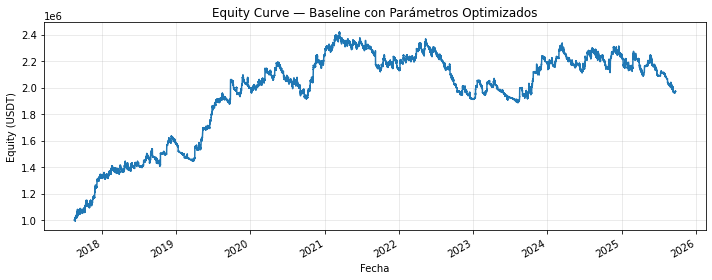


Retornos Anuales:


,Return
Year,
2017,0.3262
2018,0.1910
2019,0.2621
2020,0.1280
2021,-0.0463
2022,-0.1080
2023,0.1439
2024,0.0252
2025,-0.1207



Retornos Mensuales:


Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0627,0.0182,0.0292,0.1146,0.0684
2018,0.0019,0.0290,0.0279,-0.0021,0.0026,0.0034,0.0223,0.0437,-0.0400,0.0439,0.0583,-0.0107
2019,-0.0506,-0.0225,-0.0021,0.0538,0.0976,0.0900,0.0231,0.0178,0.0631,-0.0415,0.0474,-0.0274
2020,0.0078,0.0299,0.0181,0.0167,-0.0048,-0.0314,-0.0100,-0.0202,-0.0337,0.0689,0.0687,0.0172
2021,0.0183,0.0404,-0.0114,-0.0036,-0.0073,0.0008,-0.0046,-0.0312,-0.0561,0.0267,-0.0116,-0.0040
2022,0.0319,-0.0009,0.0334,-0.0029,0.0106,-0.0178,-0.0270,-0.0262,-0.0561,-0.0343,-0.0012,-0.0194
2023,0.0675,-0.0425,0.0327,-0.0085,-0.0229,-0.0166,-0.0094,0.0214,0.0056,0.0813,0.0127,0.0209
2024,-0.0124,0.0601,-0.0150,-0.0392,0.0018,-0.0118,0.0392,-0.0016,-0.0019,-0.0279,0.0526,-0.0136
2025,-0.0439,0.0464,-0.0416,0.0050,0.0041,-0.0367,0.0040,-0.0322,-0.0290,NaN,NaN,NaN



Retornos Trimestrales:


Quarter,1,2,3,4
Year,,,,
2017,NaN,NaN,0.0820,0.2256
2018,0.0598,0.0039,0.0242,0.0929
2019,-0.0739,0.2608,0.1070,-0.0236
2020,0.0567,-0.0199,-0.0627,0.1621
2021,0.0473,-0.0101,-0.0898,0.0107
2022,0.0653,-0.0103,-0.1056,-0.0542
2023,0.0555,-0.0472,0.0174,0.1179
2024,0.0313,-0.0488,0.0355,0.0093
2025,-0.0411,-0.0280,-0.0566,NaN


In [8]:
#PARTE 7: BASELINE (PRUEBA RÁPIDA CON PARÁMETROS OPTIMIZADOS)

print("\n" + "="*80)
print("EVALUACIÓN BASELINE CON PARÁMETROS OPTIMIZADOS")
print("="*80)

# Aplicar indicadores optimizados y generar señales
df_base = two_of_three_signals(add_indicators(data))

# Ejecutar backtest en todo el período
bt_all = backtest(
    df_base, 
    init_capital=1_000_000.0,
    ticket_usdt=10_000.0,
    fee_rate=0.00125,
    sl_pct=0.05,
    tp_pct=0.10
)

# Mostrar métricas
metrics_all = performance_metrics(
    bt_all["equity"], 
    trades=bt_all.get("trades"), 
    rf_annual=0.0
).round(4)

print("\nMétricas de rendimiento:")
display(metrics_all)

# Visualizar curva de equity
plt.figure(figsize=(10,4))
bt_all["equity"]["equity"].plot()
plt.title("Equity Curve — Baseline con Parámetros Optimizados")
plt.xlabel("Fecha")
plt.ylabel("Equity (USDT)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Tablas de retornos
tables_all = returns_tables(bt_all["equity"])
print("\nRetornos Anuales:")
display(tables_all["annual"])
print("\nRetornos Mensuales:")
display(tables_all["monthly"])
print("\nRetornos Trimestrales:")
display(tables_all["quarterly"])

In [9]:
#PARTE 8: BASELINE RÁPIDO (SOLO MÉTRICAS)

print("\n" + "="*80)
print("RESUMEN RÁPIDO")
print("="*80)

df_base = two_of_three_signals(add_indicators(data))
bt_all = backtest(
    df_base, 
    init_capital=1_000_000.0,
    ticket_usdt=10_000.0,
    fee_rate=0.00125,
    sl_pct=0.05,
    tp_pct=0.10
)

display(performance_metrics(
    bt_all["equity"], 
    trades=bt_all.get("trades"), 
    rf_annual=0.0
).round(4))


RESUMEN RÁPIDO


,Sharpe,Sortino,Calmar,Max Drawdown,Win Rate (bars),Win Rate (trades),CAGR,Final Equity
0,0.7933,0.9898,0.3957,-0.221,0.4935,0.3724,0.0875,1.972354e+06


In [10]:
#PARTE 9: OPTIMIZACIÓN WALK-FORWARD CON OPTUNA

def calmar_from_equity(eq: pd.DataFrame) -> float:
    """
    Calcula Calmar Ratio para función objetivo de optimización.
    
    Calmar Ratio = CAGR / |Max Drawdown|
    - Premia alto retorno con bajo drawdown
    - Métrica robusta contra overfitting
    """
    roll_max = eq["equity"].cummax()
    dd = eq["equity"] / roll_max - 1.0
    max_dd = dd.min()
    
    years = (eq.index[-1] - eq.index[0]).total_seconds() / (365.25 * 24 * 3600)
    if years <= 0:
        return -np.inf
    
    cagr = (eq["equity"].iloc[-1] / eq["equity"].iloc[0]) ** (1 / years) - 1
    return cagr / abs(max_dd) if max_dd != 0 else -np.inf

def _warmup_bars(ind_params: Dict) -> int:
    """
    Calcula el número de barras necesarias para calentar indicadores.
    
    Retorna el máximo entre todos los períodos de ventana para evitar
    que los primeros valores de los indicadores sean NaN.
    """
    return int(max(
        ind_params.get("ema_slow", 26),
        ind_params.get("macd_slow", 26),
        ind_params.get("rsi_window", 14)
    ))

def prepare_eval_chunk_with_warmup(
    df_raw: pd.DataFrame, 
    start_idx: int, 
    end_idx: int, 
    ind_params: Dict, 
    sig_params: Dict
) -> pd.DataFrame:
    """
    Prepara chunk de datos con período de warm-up para indicadores.
    
    Proceso:
    1. Extrae datos desde (start - warmup_bars) hasta end
    2. Calcula indicadores en todo el rango extendido
    3. Retorna solo el período [start:end] con indicadores completamente válidos
    
    Esto evita que los primeros valores tengan NaN por falta de historia.
    """
    w = _warmup_bars(ind_params)
    a = max(0, start_idx - w)  # No puede ser negativo
    b = end_idx
    
    # Calcular indicadores en rango extendido
    tmp = add_indicators(df_raw.iloc[a:b].copy(), **ind_params)
    tmp = two_of_three_signals(tmp, **sig_params)
    
    # Extraer solo el período objetivo (sin warm-up)
    core = tmp.iloc[(start_idx - a):(end_idx - a)].copy()
    return core

def walk_forward_expanding_returns_on_train(
    df_train: pd.DataFrame,
    k_folds: int,
    ind_params: Dict,
    sig_params: Dict,
    bt_params: Dict,
    init_equity: float = 1_000_000.0
) -> pd.DataFrame:
    """
    Simula walk-forward con ventana EXPANDING (creciente).
    
    Metodología:
    1. Divide train en k_folds temporales
    2. Para cada fold: ejecuta backtest solo en ese período
    3. Concatena retornos de todos los folds
    4. Compone equity continuo
    
    Ventajas:
    - Simula trading "en vivo" sin mirar al futuro
    - Evita overfitting al período completo
    - Más realista que backtest simple
    
    Args:
        df_train: DataFrame de entrenamiento
        k_folds: Número de períodos de evaluación
        ind_params: Parámetros de indicadores técnicos
        sig_params: Parámetros de umbrales de señales
        bt_params: Parámetros de backtest (capital, fees, etc)
        init_equity: Capital inicial
    
    Returns:
        DataFrame con equity continuo a lo largo de todos los folds
    """
    n = len(df_train)
    # Calcular índices de inicio/fin de cada fold
    edges = [int(n * i / k_folds) for i in range(k_folds + 1)]
    
    rets = []  # Lista para acumular retornos de cada fold
    
    for f in range(k_folds):
        eval_start = edges[f]
        eval_end = edges[f + 1]
        
        # Saltar fold si no hay suficiente historia para warm-up
        if eval_start < max(2000, _warmup_bars(ind_params)):
            continue
        
        # Preparar chunk con warm-up para indicadores válidos
        chunk = prepare_eval_chunk_with_warmup(
            df_train, eval_start, eval_end, 
            ind_params, sig_params
        )
        
        # Ejecutar backtest en este fold específico
        bt = backtest(chunk, **bt_params)
        
        # Extraer retornos del fold
        r = bt["equity"]["equity"].pct_change().fillna(0.0)
        rets.append(r)
    
    # Verificar que al menos un fold fue válido
    if not rets:
        raise RuntimeError("WF expanding: no hay folds válidos (historial insuficiente).")
    
    # Concatenar retornos de todos los folds
    ret_concat = pd.concat(rets).sort_index()
    
    # Componer equity continuo
    eq_cont = init_equity * (1.0 + ret_concat).cumprod()
    eq_df = pd.DataFrame({"equity": eq_cont})
    
    return eq_df

def make_param_sampler(trial):
    """
    Define el espacio de búsqueda para optimización con Optuna.
    
    IMPORTANTE: Los valores optimizados de PARTE 4 sirven como guía.
    Optuna explorará variaciones alrededor de estos valores óptimos.
    
    Rangos de búsqueda:
    - Indicadores: ventanas cortas a largas
    - Umbrales: conservadores a agresivos
    - Gestión de riesgo: posiciones pequeñas a grandes, SL/TP ajustables
    
    Returns:
        Tupla (ind_params, sig_params, bt_params)
    """
    # Parámetros de indicadores técnicos
    ind = dict(
        rsi_window = trial.suggest_int("rsi_window", 6, 60),     # 6-60 períodos
        ema_fast = trial.suggest_int("ema_fast", 5, 30),         # EMA rápida
        ema_slow = trial.suggest_int("ema_slow", 20, 140),       # EMA lenta
        macd_fast = trial.suggest_int("macd_fast", 6, 20),       # MACD rápido
        macd_slow = trial.suggest_int("macd_slow", 16, 40),      # MACD lento
        macd_signal= trial.suggest_int("macd_signal", 5, 15),    # Línea de señal
    )
    
    # Umbrales de señales (rangos amplios para exploración)
    sig = dict(
        rsi_lo = trial.suggest_int("rsi_lo", 15, 40),            # Sobreventa: 15-40
        rsi_hi = trial.suggest_int("rsi_hi", 60, 85),            # Sobrecompra: 60-85
        ema_bias = trial.suggest_float("ema_bias", -10.0, 10.0), # Sesgo EMA
        macd_bias= trial.suggest_float("macd_bias", -10.0, 10.0),# Sesgo MACD
    )
    
    # Parámetros de gestión de riesgo y backtesting
    bt = dict(
        init_capital=1_000_000.0,                                       # Fijo
        ticket_usdt=trial.suggest_int("ticket_usdt", 10_000, 100_000, step=1_000), # Tamaño posición
        fee_rate=0.00125,                                              # 0.125% fijo
        sl_pct=trial.suggest_float("sl_pct", 0.01, 0.15),             # Stop-loss: 1-15%
        tp_pct=trial.suggest_float("tp_pct", 0.02, 0.25),             # Take-profit: 2-25%
    )
    
    return ind, sig, bt

def objective_walkforward_expanding(trial, df_train: pd.DataFrame, k_folds: int = 5) -> float:
    """
    Función objetivo para Optuna (maximizar Calmar Ratio).
    
    Esta función:
    1. Muestrea parámetros del espacio de búsqueda
    2. Ejecuta walk-forward expanding en train
    3. Calcula Calmar Ratio del equity resultante
    4. Retorna métrica para que Optuna la maximice
    
    Args:
        trial: Objeto trial de Optuna
        df_train: Datos de entrenamiento
        k_folds: Número de folds para walk-forward
    
    Returns:
        Calmar Ratio (CAGR / |Max DD|)
    """
    # Muestrear parámetros de este trial
    ind_params, sig_params, bt_params = make_param_sampler(trial)
    
    # Ejecutar walk-forward en train con estos parámetros
    eq_cont = walk_forward_expanding_returns_on_train(
        df_train, k_folds, ind_params, sig_params, bt_params
    )
    
    # Calcular y retornar métrica objetivo
    return calmar_from_equity(eq_cont)

# EJECUCIÓN DE OPTIMIZACIÓN

# Dividir dataset en train/test/valid (60/20/20)
sp = time_splits_idx(len(data))
df_train = slice_df(data, sp["train"])
df_test = slice_df(data, sp["test"])
df_valid = slice_df(data, sp["valid"])

print("\n" + "="*80)
print("OPTIMIZACIÓN BAYESIANA CON OPTUNA")
print("="*80)
print(f"Train: {len(df_train)} barras | {df_train.iloc[0]['datetime']} → {df_train.iloc[-1]['datetime']}")
print(f"Test:  {len(df_test)} barras | {df_test.iloc[0]['datetime']} → {df_test.iloc[-1]['datetime']}")
print(f"Valid: {len(df_valid)} barras | {df_valid.iloc[0]['datetime']} → {df_valid.iloc[-1]['datetime']}")

# Crear estudio de optimización
study = optuna.create_study(
    direction="maximize",  # Maximizar Calmar Ratio
    sampler=optuna.samplers.TPESampler(seed=42)  # Reproducibilidad
)

# Ejecutar optimización (60 trials)
print("\nEjecutando optimización... (esto puede tardar varios minutos)")
study.optimize(
    lambda tr: objective_walkforward_expanding(tr, df_train, k_folds=5), 
    n_trials=60,  # Número de combinaciones a probar
    show_progress_bar=False
)

# Mostrar resultados
print("\n=== RESULTADOS DE OPTIMIZACIÓN (TRAIN WF expanding, objetivo Calmar continuo) ===")
print(f"Mejor Calmar Ratio (WF TRAIN): {study.best_value:.4f}")
print("\nParámetros óptimos encontrados:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

# Extraer mejores parámetros encontrados
bp = study.best_params

# Organizar parámetros por categoría
ind_best = dict(
    rsi_window=int(bp["rsi_window"]),
    ema_fast=int(bp["ema_fast"]),
    ema_slow=int(bp["ema_slow"]),
    macd_fast=int(bp["macd_fast"]),
    macd_slow=int(bp["macd_slow"]),
    macd_signal=int(bp["macd_signal"])
)

sig_best = dict(
    rsi_lo=float(bp["rsi_lo"]),
    rsi_hi=float(bp["rsi_hi"]),
    ema_bias=float(bp["ema_bias"]),
    macd_bias=float(bp["macd_bias"])
)

bt_best = dict(
    init_capital=1_000_000.0,
    ticket_usdt=int(bp["ticket_usdt"]),
    fee_rate=0.00125,
    sl_pct=float(bp["sl_pct"]),
    tp_pct=float(bp["tp_pct"])
)

# Reconstruir equity usado en el objetivo de optimización
eq_wf = walk_forward_expanding_returns_on_train(
    df_train, k_folds=5, 
    ind_params=ind_best, 
    sig_params=sig_best, 
    bt_params=bt_best
)

print("\nMétricas del equity optimizado (WF TRAIN, continuo):")
display(performance_metrics(eq_wf, rf_annual=0.0).round(4))

[I 2025-10-06 23:06:30,524] A new study created in memory with name: no-name-3bddccb9-f828-4d90-8258-7c0bacfa9e21



OPTIMIZACIÓN BAYESIANA CON OPTUNA
Train: 42496 barras | 2017-08-17 04:00:00+00:00 → 2022-06-28 01:00:00+00:00
Test:  14165 barras | 2022-06-28 02:00:00+00:00 → 2024-02-08 07:00:00+00:00
Valid: 14166 barras | 2024-02-08 08:00:00+00:00 → 2025-09-22 23:00:00+00:00

Ejecutando optimización... (esto puede tardar varios minutos)


[I 2025-10-06 23:06:43,038] Trial 0 finished with value: 0.6073331161746957 and parameters: {'rsi_window': 26, 'ema_fast': 29, 'ema_slow': 108, 'macd_fast': 14, 'macd_slow': 19, 'macd_signal': 6, 'rsi_lo': 16, 'rsi_hi': 82, 'ema_bias': 2.0223002348641756, 'macd_bias': 4.161451555920909, 'ticket_usdt': 11000, 'sl_pct': 0.1457873793026792, 'tp_pct': 0.211461807384097}. Best is trial 0 with value: 0.6073331161746957.
[I 2025-10-06 23:06:51,053] Trial 1 finished with value: 0.8394748736750623 and parameters: {'rsi_window': 17, 'ema_fast': 9, 'ema_slow': 42, 'macd_fast': 10, 'macd_slow': 29, 'macd_signal': 9, 'rsi_lo': 22, 'rsi_hi': 75, 'ema_bias': -7.210122786959163, 'macd_bias': -4.157107029295637, 'ticket_usdt': 43000, 'sl_pct': 0.07384979779038502, 'tp_pct': 0.20059047112039313}. Best is trial 1 with value: 0.8394748736750623.
[I 2025-10-06 23:06:59,072] Trial 2 finished with value: 0.8321807222935272 and parameters: {'rsi_window': 16, 'ema_fast': 18, 'ema_slow': 91, 'macd_fast': 6, 'ma

[I 2025-10-06 23:10:33,027] Trial 20 finished with value: 0.16928707372230822 and parameters: {'rsi_window': 47, 'ema_fast': 5, 'ema_slow': 136, 'macd_fast': 12, 'macd_slow': 40, 'macd_signal': 14, 'rsi_lo': 27, 'rsi_hi': 72, 'ema_bias': -6.43616328172447, 'macd_bias': 0.21756093416982614, 'ticket_usdt': 18000, 'sl_pct': 0.11725423453501978, 'tp_pct': 0.06435030614673035}. Best is trial 12 with value: 1.3123379305994656.
[I 2025-10-06 23:10:41,722] Trial 21 finished with value: 0.7639428570551826 and parameters: {'rsi_window': 10, 'ema_fast': 13, 'ema_slow': 31, 'macd_fast': 10, 'macd_slow': 31, 'macd_signal': 14, 'rsi_lo': 38, 'rsi_hi': 78, 'ema_bias': -8.566269189463693, 'macd_bias': -5.462273262666224, 'ticket_usdt': 38000, 'sl_pct': 0.10568552097230345, 'tp_pct': 0.16992068790114878}. Best is trial 12 with value: 1.3123379305994656.
[I 2025-10-06 23:10:50,366] Trial 22 finished with value: 0.7686671835189725 and parameters: {'rsi_window': 7, 'ema_fast': 17, 'ema_slow': 35, 'macd_fa

[I 2025-10-06 23:13:47,428] Trial 40 finished with value: 0.08986591388383632 and parameters: {'rsi_window': 18, 'ema_fast': 16, 'ema_slow': 97, 'macd_fast': 8, 'macd_slow': 28, 'macd_signal': 15, 'rsi_lo': 37, 'rsi_hi': 78, 'ema_bias': 1.1332886324592888, 'macd_bias': 0.1318577135572756, 'ticket_usdt': 65000, 'sl_pct': 0.09095521787523936, 'tp_pct': 0.19615149420927824}. Best is trial 31 with value: 1.563749462566411.
[I 2025-10-06 23:13:57,352] Trial 41 finished with value: 1.0227813728222879 and parameters: {'rsi_window': 27, 'ema_fast': 17, 'ema_slow': 36, 'macd_fast': 9, 'macd_slow': 36, 'macd_signal': 11, 'rsi_lo': 28, 'rsi_hi': 80, 'ema_bias': -3.301597926267262, 'macd_bias': -6.927213081448121, 'ticket_usdt': 16000, 'sl_pct': 0.11490968617666689, 'tp_pct': 0.15303069542940934}. Best is trial 31 with value: 1.563749462566411.
[I 2025-10-06 23:14:06,502] Trial 42 finished with value: 1.2706202500503287 and parameters: {'rsi_window': 33, 'ema_fast': 19, 'ema_slow': 24, 'macd_fast'


=== RESULTADOS DE OPTIMIZACIÓN (TRAIN WF expanding, objetivo Calmar continuo) ===
Mejor Calmar Ratio (WF TRAIN): 1.8854

Parámetros óptimos encontrados:
  rsi_window: 8
  ema_fast: 15
  ema_slow: 29
  macd_fast: 16
  macd_slow: 31
  macd_signal: 15
  rsi_lo: 22
  rsi_hi: 85
  ema_bias: -9.329736712225614
  macd_bias: -0.16684763293562432
  ticket_usdt: 39000
  sl_pct: 0.1026530734551946
  tp_pct: 0.22442655255123536

Métricas del equity optimizado (WF TRAIN, continuo):


,Sharpe,Sortino,Calmar,Max Drawdown,Win Rate (bars),Win Rate (trades),CAGR,Final Equity
0,1.6102,1.9554,1.8854,-0.4826,0.5079,NaN,0.9099,1.235976e+07



EVALUACIÓN EN CONJUNTOS DE PRUEBA

Métricas TEST (parámetros optimizados):


,Sharpe,Sortino,Calmar,Max Drawdown,Win Rate (bars),Win Rate (trades),CAGR,Final Equity
0,-0.0746,-0.087,-0.1845,-0.4871,0.5034,0.272,-0.0899,858821.26



Métricas VALID (parámetros optimizados):


,Sharpe,Sortino,Calmar,Max Drawdown,Win Rate (bars),Win Rate (trades),CAGR,Final Equity
0,-0.1273,-0.1493,-0.2198,-0.4579,0.4864,0.2955,-0.1006,841880.2058



PORTAFOLIO FINAL CON PARÁMETROS OPTIMIZADOS (DATASET COMPLETO)

Métricas del portafolio completo:


,Sharpe,Sortino,Calmar,Max Drawdown,Win Rate (bars),Win Rate (trades),CAGR,Final Equity
0,0.5896,0.6576,0.2993,-0.5844,0.5027,0.3519,0.1749,3.691489e+06


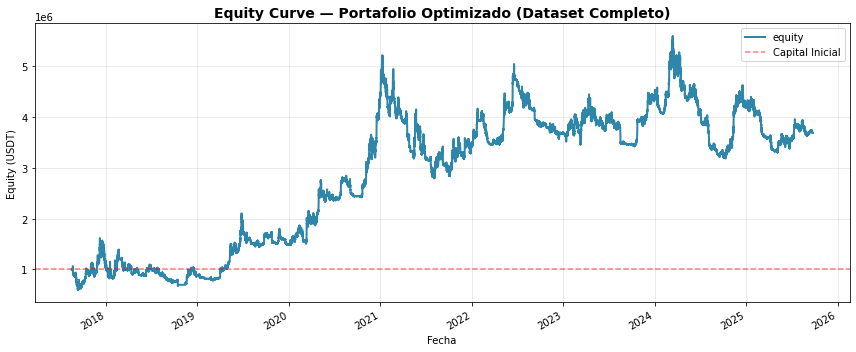


=== Rendimientos Anuales ===


,Return
Year,
2017,0.0589
2018,-0.1761
2019,0.7059
2020,1.9857
2021,-0.2143
2022,0.0579
2023,0.1778
2024,-0.0339
2025,-0.1217



=== Rendimientos Mensuales ===


Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0988,-0.1497,0.2752,0.1646,-0.0695
2018,-0.2128,0.4263,-0.1185,-0.0716,-0.0800,0.1342,-0.0638,-0.1431,-0.0691,-0.0795,0.3055,-0.0424
2019,-0.0588,-0.0253,0.0532,0.2304,0.4202,0.2611,-0.1532,-0.0124,0.0657,-0.0793,0.0606,-0.0795
2020,0.1283,-0.0797,0.2475,0.2659,-0.0008,-0.0229,0.1519,-0.0136,-0.0975,0.1267,0.2977,0.2439
2021,-0.0504,0.0017,-0.0708,-0.1526,0.0918,-0.1216,-0.0778,0.0810,-0.0699,0.1031,-0.0140,0.0846
2022,0.1240,-0.0759,-0.0330,0.0432,0.1203,0.1316,-0.0694,-0.0398,-0.0669,-0.0211,-0.0273,0.0032
2023,0.0379,-0.0052,0.0797,0.0028,-0.0507,0.0086,-0.0375,-0.0864,-0.0035,0.1332,0.0191,0.0871
2024,-0.0631,0.2238,0.0442,-0.1434,-0.0092,-0.0657,-0.0705,-0.1220,-0.0273,0.0589,0.2501,-0.0317
2025,0.0110,-0.0897,-0.0690,-0.0743,0.0512,0.0167,0.0626,-0.0378,0.0135,NaN,NaN,NaN



=== Rendimientos Trimestrales ===


Quarter,1,2,3,4
Year,,,,
2017,NaN,NaN,-0.2338,0.3819
2018,-0.0103,-0.0312,-0.2532,0.1508
2019,-0.0337,1.2037,-0.1088,-0.1011
2020,0.2953,0.2359,0.0255,0.8187
2021,-0.1161,-0.1873,-0.0728,0.1796
2022,0.0044,0.3224,-0.1663,-0.0447
2023,0.1148,-0.0398,-0.1236,0.2554
2024,0.1973,-0.2071,-0.2061,0.2818
2025,-0.1432,-0.0107,0.0362,NaN



ANÁLISIS DE TRADES

Resumen por tipo de operación:


pnl                                                     ret          \
      count       mean           sum        min         max    mean     std   
side                                                                          
long   4799  1494.5476  7.172334e+06 -6881.8995  12491.6489  0.0383  0.1716   
short  3671 -1283.9149 -4.713252e+06 -8133.3812  13410.8826 -0.0329  0.1487   

                       
          min     max  
side                   
long  -0.1765  0.3203  
short -0.2085  0.3439


Total de trades: 8470
Trades ganadores: 2981 (35.19%)
Trades perdedores: 5489 (64.81%)
P&L total: $2,459,082.53
P&L promedio: $290.33


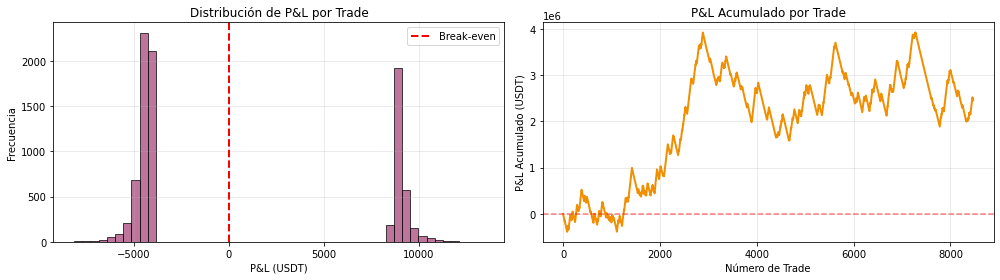


Duración promedio de trades: 543.90 horas
Duración mínima: 1.00 horas
Duración máxima: 5362.00 horas

COMPARACIÓN DE RENDIMIENTO POR CONJUNTO


,Sharpe,Sortino,Calmar,Max Drawdown,Win Rate (bars),Win Rate (trades),CAGR,Final Equity
Train (WF),1.6102,1.9554,1.8854,-0.4826,0.5079,NaN,0.9099,1.235976e+07
Test,-0.0746,-0.0870,-0.1845,-0.4871,0.5034,0.2720,-0.0899,8.588213e+05
Valid,-0.1273,-0.1493,-0.2198,-0.4579,0.4864,0.2955,-0.1006,8.418802e+05
Todo,0.5896,0.6576,0.2993,-0.5844,0.5027,0.3519,0.1749,3.691489e+06



FIN DEL ANÁLISIS

 Optimización y evaluación completadas exitosamente
 Capital inicial: $1,000,000
 Capital final: $3,691,489.19
 Retorno total: 269.15%


In [11]:
#PARTE 10: EVALUACIÓN EN TEST/VALID Y RESUMEN COMPLETO

print("\n" + "="*80)
print("EVALUACIÓN EN CONJUNTOS DE PRUEBA")
print("="*80)

# ---- BACKTEST EN TEST CON PARÁMETROS OPTIMIZADOS ----
# Aplicar indicadores optimizados al conjunto de test
df_test_with_signals = two_of_three_signals(
    add_indicators(df_test, **ind_best), 
    **sig_best
)

# Ejecutar backtest en test
bt_test_best = backtest(df_test_with_signals, **bt_best)

print("\nMétricas TEST (parámetros optimizados):")
display(performance_metrics(
    bt_test_best["equity"], 
    trades=bt_test_best.get("trades"), 
    rf_annual=0.0
).round(4))

# ---- BACKTEST EN VALID CON PARÁMETROS OPTIMIZADOS ----
# Aplicar indicadores optimizados al conjunto de validación
df_valid_with_signals = two_of_three_signals(
    add_indicators(df_valid, **ind_best), 
    **sig_best
)

# Ejecutar backtest en valid
bt_valid_best = backtest(df_valid_with_signals, **bt_best)

print("\nMétricas VALID (parámetros optimizados):")
display(performance_metrics(
    bt_valid_best["equity"], 
    trades=bt_valid_best.get("trades"), 
    rf_annual=0.0
).round(4))

# ---- PORTAFOLIO OPTIMIZADO EN TODO EL DATASET ----
print("\n" + "="*80)
print("PORTAFOLIO FINAL CON PARÁMETROS OPTIMIZADOS (DATASET COMPLETO)")
print("="*80)

# Aplicar parámetros optimizados a TODO el dataset
df_opt = two_of_three_signals(
    add_indicators(data, **ind_best), 
    **sig_best
)

# Ejecutar backtest completo
bt_opt = backtest(df_opt, **bt_best)

# Mostrar métricas finales
print("\nMétricas del portafolio completo:")
display(performance_metrics(
    bt_opt["equity"], 
    trades=bt_opt.get("trades"), 
    rf_annual=0.0
).round(4))

# ---- VISUALIZACIÓN DE EQUITY CURVE ----
plt.figure(figsize=(12, 5))
bt_opt["equity"]["equity"].plot(linewidth=2, color='#2E86AB')
plt.title("Equity Curve — Portafolio Optimizado (Dataset Completo)", 
          fontsize=14, fontweight='bold')
plt.xlabel("Fecha")
plt.ylabel("Equity (USDT)")
plt.grid(True, alpha=0.3)
plt.axhline(y=1_000_000, color='red', linestyle='--', alpha=0.5, label='Capital Inicial')
plt.legend()
plt.tight_layout()
plt.show()

# ---- TABLAS DE RETORNOS ----
tables_opt = returns_tables(bt_opt["equity"])

print("\n=== Rendimientos Anuales ===")
display(tables_opt["annual"])

print("\n=== Rendimientos Mensuales ===")
display(tables_opt["monthly"])

print("\n=== Rendimientos Trimestrales ===")
display(tables_opt["quarterly"])

# ---- ANÁLISIS DETALLADO DE TRADES ----
print("\n" + "="*80)
print("ANÁLISIS DE TRADES")
print("="*80)

if len(bt_opt["trades"]) > 0:
    # Resumen por tipo de operación (long/short)
    trades_summary = bt_opt["trades"].groupby("side").agg({
        "pnl": ["count", "mean", "sum", "min", "max"],
        "ret": ["mean", "std", "min", "max"]
    }).round(4)
    
    print("\nResumen por tipo de operación:")
    display(trades_summary)
    
    # Estadísticas generales
    total_trades = len(bt_opt["trades"])
    winning_trades = (bt_opt["trades"]["pnl"] > 0).sum()
    losing_trades = (bt_opt["trades"]["pnl"] < 0).sum()
    
    print(f"\nTotal de trades: {total_trades}")
    print(f"Trades ganadores: {winning_trades} ({winning_trades/total_trades*100:.2f}%)")
    print(f"Trades perdedores: {losing_trades} ({losing_trades/total_trades*100:.2f}%)")
    print(f"P&L total: ${bt_opt['trades']['pnl'].sum():,.2f}")
    print(f"P&L promedio: ${bt_opt['trades']['pnl'].mean():,.2f}")
    
    # ---- VISUALIZACIÓN: DISTRIBUCIÓN DE P&L ----
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    # Histograma de P&L
    axes[0].hist(bt_opt["trades"]["pnl"], bins=50, edgecolor='black', alpha=0.7, color='#A23B72')
    axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Break-even')
    axes[0].set_title("Distribución de P&L por Trade")
    axes[0].set_xlabel("P&L (USDT)")
    axes[0].set_ylabel("Frecuencia")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Retornos acumulados de trades
    bt_opt["trades"]["cumulative_pnl"] = bt_opt["trades"]["pnl"].cumsum()
    axes[1].plot(range(len(bt_opt["trades"])), bt_opt["trades"]["cumulative_pnl"], 
                 linewidth=2, color='#F18F01')
    axes[1].set_title("P&L Acumulado por Trade")
    axes[1].set_xlabel("Número de Trade")
    axes[1].set_ylabel("P&L Acumulado (USDT)")
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # ---- ANÁLISIS DE DURACIÓN DE TRADES ----
    bt_opt["trades"]["duration"] = (
        pd.to_datetime(bt_opt["trades"]["exit_time"]) - 
        pd.to_datetime(bt_opt["trades"]["entry_time"])
    ).dt.total_seconds() / 3600  # Convertir a horas
    
    print(f"\nDuración promedio de trades: {bt_opt['trades']['duration'].mean():.2f} horas")
    print(f"Duración mínima: {bt_opt['trades']['duration'].min():.2f} horas")
    print(f"Duración máxima: {bt_opt['trades']['duration'].max():.2f} horas")
    
else:
    print("\n  No se ejecutaron trades en el período analizado.")
    print("Esto puede indicar que los parámetros son demasiado conservadores")
    print("o que las condiciones de mercado no generaron señales.")

# ---- COMPARACIÓN TRAIN/TEST/VALID ----
print("\n" + "="*80)
print("COMPARACIÓN DE RENDIMIENTO POR CONJUNTO")
print("="*80)

comparison = pd.DataFrame({
    "Train (WF)": performance_metrics(eq_wf, rf_annual=0.0).iloc[0],
    "Test": performance_metrics(bt_test_best["equity"], trades=bt_test_best.get("trades"), rf_annual=0.0).iloc[0],
    "Valid": performance_metrics(bt_valid_best["equity"], trades=bt_valid_best.get("trades"), rf_annual=0.0).iloc[0],
    "Todo": performance_metrics(bt_opt["equity"], trades=bt_opt.get("trades"), rf_annual=0.0).iloc[0]
}).T

display(comparison.round(4))

print("\n" + "="*80)
print("FIN DEL ANÁLISIS")
print("="*80)
print("\n Optimización y evaluación completadas exitosamente")
print(f" Capital inicial: $1,000,000")
print(f" Capital final: ${bt_opt['equity']['equity'].iloc[-1]:,.2f}")
print(f" Retorno total: {(bt_opt['equity']['equity'].iloc[-1]/1_000_000 - 1)*100:.2f}%")